# Initialize Libraries and Constants

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/Shareddrives/CS6220_FinalProject/facenet/

/content/drive/Shareddrives/CS6220_FinalProject/facenet


In [ ]:
from time import time
from datetime import datetime
import os
import matplotlib.pyplot as plt

In [ ]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 5.3 MB/s 


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

In [ ]:
# Constants
MAPPING_FILE_PATH = '/content/drive/Shareddrives/CS6220_FinalProject/meta/identity_meta_fixed.csv'
OUTPUT_NAME = 'data_new.pt'
ORIGINAL_DATASET = '/content/drive/Shareddrives/CS6220_FinalProject/cs6220_dataset/'
RESULTS_FILENAME = 'facenet_high_amogh.csv'

num_classes = 40
# data_dir = 'train'
data_dir = '/content/drive/Shareddrives/CS6220_FinalProject/facenet/train_high_cropped' # CHANGE this if you want to change perturbation level
models_dir = '/content/drive/Shareddrives/CS6220_FinalProject/facenet/models'
batch_size = 16
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


# Create the training dataset (cropped images)

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [(p, p.replace(data_dir, data_dir + '_cropped')) for p, _ in dataset.samples]
        
loader = DataLoader(
    dataset, num_workers=workers, batch_size=batch_size, collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

# Train the model

In [ ]:
torch.cuda.empty_cache()

try:
    del resnet
except:
    pass

resnet = InceptionResnetV1(
    classify=True,
    # pretrained='vggface2',
    num_classes=num_classes
)
if torch.cuda.is_available():
    resnet.cuda()

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir, transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

history = {
    'tacc': [],
    'vacc':[],
    'tloss':[],
    'vloss':[]
}

In [ ]:
# writer = SummaryWriter()
# writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    # writer=writer
)

ckpt = ""
accu = 0.5 # Minimum accuracy required to be achieved for the model to get saved
for epoch in range(epochs):
    a = time()
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    tloss, tmets = training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        # writer=writer
    )

    resnet.eval()
    vloss, vmets = training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        # writer=writer
    )
    history['tacc'].append(tmets['acc'].item())
    history['vacc'].append(vmets['acc'].item())
    history['tloss'].append(tloss.item())
    history['vloss'].append(vloss.item())
# Save best model
    if vmets['acc'] > accu:
        accu = vmets['acc']
        ckpt = datetime.now().strftime('%d-%m-%y_%H-%M') + "_{:02d}_{:02f}.pth".format(epoch + 1, accu)
        ckpt = os.path.join(models_dir, ckpt)
        print("Saving new best model to {:}.".format(ckpt))
        torch.save({
            'epoch': epoch,
            'model': resnet.state_dict(),
            'optim': optimizer.state_dict(),
            'vaccu': accu
            }, ckpt)

    print("Time taken: {}".format(time() - a))
# writer.close()
# resnet.cpu()  # send resnet back to cpu



Initial
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid |    90/90   | loss:    3.6889 | fps:  141.9456 | acc:    0.0264   

Epoch 1/8
----------
Train |   359/359  | loss:    3.1637 | fps:   40.6316 | acc:    0.1610   
Valid |    90/90   | loss:    2.7709 | fps:  195.8728 | acc:    0.2734   
Time taken: 213.99927496910095

Epoch 2/8
----------
Train |   359/359  | loss:    2.0100 | fps:   52.1793 | acc:    0.4032   
Valid |    90/90   | loss:    1.5666 | fps:  195.9753 | acc:    0.5190   
Saving new best model to /content/drive/Shareddrives/CS6220_FinalProject/facenet/models/29-11-21_16-15_02_0.518964.pth.
Time taken: 120.98278212547302

Epoch 3/8
----------
Train |   359/359  | loss:    1.4905 | fps:   52.0668 | acc:    0.5526   
Valid |    90/90   | loss:    1.1706 | fps:  194.6938 | acc:    0.6591   
Saving new best model to /content/drive/Shareddrives/CS6220_FinalProject/facenet/models/29-11-21_16-17_03_0.659135.pth.
Time taken: 120.98216962814331

Epoch 4/8
----------
Train |   359/359  | loss:    1.2179 | fps:   52.1367 | acc: 

In [ ]:
def load_finetuned_resnet(model_path):
    """
    Method to load the best model.

    Parameters
    ----------
    model_path : str
        Path to model to be loaded
    num_classes : int
        Number of classes

    Returns
    -------
    torch.nn
        Finetuned Inception-Resnetv1 pytorch model

    """
    resnet = InceptionResnetV1(classify=True, num_classes=40)
    if torch.cuda.is_available():
      model = torch.load(model_path)
    else:
      model = torch.load(model_path, map_location=torch.device('cpu'))
    resnet.load_state_dict(model["model"])
    resnet.eval()
    return resnet

In [ ]:
resnet = load_finetuned_resnet(models_dir + '/29-11-21_16-27_08_0.837340.pth')

In [ ]:
def plot_lr_curve(history):
    """
    Method to plot learning curve.

    Parameters
    ----------
    history : dict
        Details about training
        
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history['tacc'], label="train_acc")
    axes[0].plot(history['vacc'], label="val_acc")
    axes[0].set_xlabel("epochs")
    axes[0].set_ylabel("acc")
    axes[1].plot(history['tloss'], label="train_loss")
    axes[1].plot(history['vloss'], label="val_loss")
    axes[1].set_xlabel("epochs")
    axes[1].set_ylabel("loss")
    plt.suptitle("Learning Curve", fontsize=16)
    axes[0].legend()
    axes[1].legend()
    plt.show()

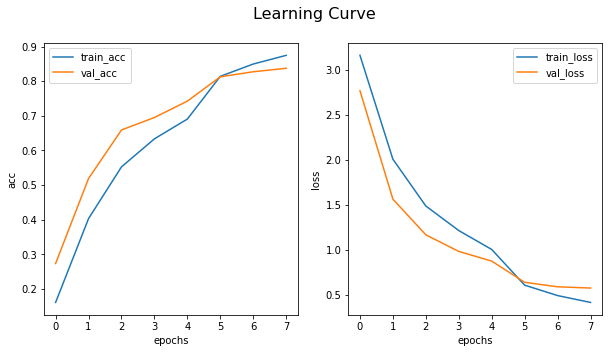

In [ ]:
plot_lr_curve(history)

# Create embeddings

In [ ]:
# Create embeddings
dataset = datasets.ImageFolder(data_dir)
idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}

# Send resnet back to cpu
resnet.cpu()

def collate_fn(x):
    return x[0]

mtcnn = MTCNN(image_size=240, margin=0, min_face_size=20)
loader = DataLoader(dataset, collate_fn=collate_fn)

# face_list = []  # list of cropped faces from photos folder
name_list = []  # list of names corrospoing to cropped photos
embedding_list = []  # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet
print("Starting loading: ", len(idx_to_class))
iteration = 0
previous_idx = -1
for img, idx in loader:
    if previous_idx != idx:
        previous_idx = idx
        iteration = 0
        print("Iteration: ", idx)
    print("File: ................................... " + str(iteration), end='\r')
    iteration += 1
    face, prob = mtcnn(img, return_prob=True)
    if face is not None and prob > 0.90:  # if face detected and probability > 90%
        emb = resnet(face.unsqueeze(0))  # passing cropped face into resnet model to get embedding matrix
        embedding_list.append(emb.detach())  # resulten embedding matrix is stored in a list
        name_list.append(idx_to_class[idx])  # names are stored in a list

data = [embedding_list, name_list]
torch.save(data, OUTPUT_NAME)  # saving data.pt file

Starting loading:  40
Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39


In [ ]:
embedding_list.shape

In [ ]:
mtcnn = MTCNN(image_size=240, margin=0, min_face_size=20)
# Send resnet back to cpu
resnet.cpu()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

# Evaluate the model

In [ ]:
from PIL import Image
import pandas as pd
from pathlib import Path
import csv

# Helper Functions

identity_map = pd.read_csv(MAPPING_FILE_PATH)
def get_class_name(predicted_class):
    # print(predicted_class)
    # print(identity_map[identity_map['Class_ID'] == predicted_class].iloc[0]['Name'])
    return identity_map[identity_map['Class_ID'] == predicted_class].iloc[0]['Name']

def face_match(img_path, embedding_list, name_list):  # img_path= location of photo, data_path= location of data.pt
    # getting embedding matrix of the given img
    img = Image.open(img_path)
    face, prob = mtcnn(img, return_prob=True)  # returns cropped face and probability
    if face is None:
        return
    emb = resnet(face.unsqueeze(0)).detach()  # detech is to make required gradient false

    dist_list = []  # list of matched distances, minimum distance is used to identify the person

    for idx, emb_db in enumerate(embedding_list):
        dist = torch.dist(emb, emb_db).item()
        dist_list.append(dist)

    idx_min = dist_list.index(min(dist_list))
    return (name_list[idx_min], min(dist_list))

def get_results(model_path):
    results = []
    saved_data = torch.load(model_path)  # loading data.pt file
    embedding_list = saved_data[0]  # getting embedding data
    name_list = saved_data[1]  # getting list of names

    for path in Path(ORIGINAL_DATASET).iterdir():
        if 'cloaked' in str(path):
          continue
        ground_truth = get_class_name(path.stem)
        print("Iteration: ", ground_truth)
        for img in path.iterdir():
            try:
                result = face_match(img.absolute(), embedding_list, name_list)
                if result:
                    results.append({
                        "prediction": get_class_name(result[0]),
                        "truth": ground_truth,
                        "distance": result[1]
                    })
                else:
                    results.append({
                        "prediction": None,
                        "truth": ground_truth,
                        "distance": 1000000
                    })
            except:
                print("ERROR")
                print(path)
                print(img)
                print(img.absolute())
                raise
    return results

def save_results(results, filename):
    to_csv = results

    keys = to_csv[0].keys()

    with open(filename, 'w', newline='', encoding="utf-8") as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(to_csv)

In [ ]:
results_scratch = get_results(OUTPUT_NAME)
save_results(results_scratch, RESULTS_FILENAME)

Iteration:  Abdullah_II_of_Jordan
Iteration:  Agata_Passent
Iteration:  14th_Dalai_Lama
Iteration:  Ahmet_Davutoğlu
Iteration:  Adhyayan_Suman
Iteration:  Aditya_Seal
Iteration:  Annette_Bening
Iteration:  Anne,_Princess_Royal
Iteration:  Anne-Marie_Duff
Iteration:  Ante_Gotovina
Iteration:  Antonia_Kidman
Iteration:  Aníbal_Cavaco_Silva
Iteration:  Apollo_Quiboloy
Iteration:  Archana_Puran_Singh
Iteration:  Armando_Iannucci
Iteration:  Airi_Suzuki
Iteration:  Alex_Gonzaga
Iteration:  Alain_Traoré
Iteration:  Alexandra_Edenborough
Iteration:  Aishwarya_Rai_Bachchan
Iteration:  Amber_Brkich
Iteration:  Alodia_Gosiengfiao
Iteration:  Andrea_Anders
Iteration:  Ana_Rosa_Quintana
Iteration:  Andrew_Upton
Iteration:  Anna_Kalata
Iteration:  Angélique_Kidjo
Iteration:  Anne_Schedeen
Iteration:  Armin_Shimerman
Iteration:  Arsène_Wenger
Iteration:  Aya_Miyama
Iteration:  Ayumi_Hamasaki
Iteration:  Bart_Freundlich
Iteration:  Bebe_Cool
Iteration:  Ben_Falcone
Iteration:  Ben_Ofoedu
Iteration:  